# Predicting Malaria in Nigeria with Machine Learning

## Spatial Analysis

### Contributors: Brian Liggio, Jessica Sickles, Prashant Toteja, Keely Meyers

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.image as mpimg
import numpy
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import statsmodels.formula.api as smf
import statsmodels.api as sm


from gridsearch import get_results
import time
import itertools
from sklearn.linear_model import Ridge
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
def feature_to_array(file_n):
    #The input of the function is a raster file with dimentions (n pixels,m pixels), 
    #and the output is going to be an array of dimmensions (m*n,1). 
    #Each pixel is going to have a unique identifier (index in the array). 
    #This index follows the formula (i*n)+j where (i,j) is the position of the pixel in the image 
    #and n is the width of the image.
    im = mpimg.imread(file_n)  
    im_greyscale = rgb2gray(im)   
    imarray = numpy.array(im_greyscale)
    #feature=[a for a in imarray] working
    feature=[i for a in imarray for i in a]
    return feature

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])   #where did these values come from? - Stackoverflow

def read_pictures(filename):
    file_name=filename
    im = mpimg.imread(file_name)  
    im_greyscale = rgb2gray(im)

In [5]:
file_name = 'Malaria_resistance_sickle_cell.png'
resistance = feature_to_array(file_name) 

file_name ='PfMalaria_fever_porportion_to_all_illness_2015.png'
fever_proportion = feature_to_array(file_name) 

file_name = 'PfPR_2015_NGA_proportion_2_10.png'
mosquito_proportion = feature_to_array(file_name) 

file_name = 'temp_suitability.png'
temp_suitability = feature_to_array(file_name) 

file_name = 'Travel_time_to_urban_centers.png'
proximity_to_urban = feature_to_array(file_name) 

file_name = 'Urban2012.png'
urban = feature_to_array(file_name) 

file_name = 'USE_annual_mean_temp.png'
annual_mean_temp = feature_to_array(file_name) 

file_name = 'USE_cropland.png'
cropland = feature_to_array(file_name)

file_name = 'USE_prec_seasonality_013.png'
precipitation = feature_to_array(file_name)

file_name = 'USE_primary_vegetation.png'
vegetation = feature_to_array(file_name)

file_name = 'USE_temp_annual_range_2015.png'
annual_temp_range = feature_to_array(file_name)

file_name = 'Water_bodies.png'
water_bodies = feature_to_array(file_name)

# Y variable
file_name = 'PF_parasite_endemicity.png'
endemicity = feature_to_array(file_name) 

# In or outside Nigeria
file_name = 'Land_coverage.png'
land_coverage = feature_to_array(file_name) 

RuntimeError: Error setting jump

file_name='Primary Vegetated Areas_2000.png'

im = mpimg.imread(file_name)  
im_greyscale = rgb2gray(im)   
imarray = numpy.array(im_greyscale)
feature=[a for a in imarray]  #iterable one level out
feature

In [6]:
######## Is filtering needed given we already scaled?

#cases = list(case/np.max(case)) # Normalize
#inorout = list(1-(land_coverage/np.max(land_coverage))) # get binary value indicating whether pixel is inside Nigeria or not
#len(inorout)




In [7]:
data = pd.DataFrame([resistance, fever_proportion, mosquito_proportion, temp_suitability, proximity_to_urban, urban, annual_mean_temp, cropland, precipitation, vegetation, annual_temp_range, water_bodies, endemicity]).T

data.columns = ['Resistance','Fever_prop','Mosquito_prop', 'Temp_suitability','Proximity_to_urban','Urban','Annual_mean_temp','Cropland','Precipitation', 'Vegetation', 'Annual_temp_range', 'Water_bodies', 'Endemicity']
#data['Endemicity'] = np.where(data['Endemicity'] == 0,1,0)   #making it a classification problem


In [8]:
######## Is filtering needed given we already scaled?

#Data_filt = Data[np.array(inorout) == 1.0] #filter dataset to only pixels within Nigeria
#Data_filt.columns = ['Resistance','Fever_prop','Mosquito_prop', 'Temp_suitability','Proximity_to_urban','Urban','Annual_mean_temp','Cropland','Precipitation', 'Vegetation', 'Annual_temp_range', 'Water_bodies', 'Endemicity']
#Data_filt['Endemicity'] = np.where(Data_filt['Endemicity'] == 0,1,0) # Transform Case label into 1 (=case) or 0 (=no case)

data.Endemicity.unique()



array([1.        , 0.9254902 , 0.72549021, 0.53333336, 0.42352942,
       0.32549021, 0.26274511, 0.21176471, 0.18039216, 0.28235295,
       0.49803922, 0.63529414, 0.62352943, 0.65490198, 0.64313728,
       0.55686277, 0.53725493, 0.5411765 , 0.68235296, 0.95686275,
       0.78039217, 0.56078434, 0.40392157, 0.30588236, 0.29803923,
       0.49411765, 0.80000001, 0.99607843, 0.98823529, 0.70588237,
       0.16078432, 0.14901961, 0.25098041, 0.96078432, 0.63137257,
       0.32941177, 0.31764707, 0.45882353, 0.50980395, 0.5529412 ,
       0.67450982, 0.90588236, 0.97647059, 0.89803922, 0.54901963,
       0.52549022, 0.56470591, 0.78431374, 0.81176472, 0.86274511,
       0.96470588, 0.89019608, 0.9137255 , 0.99215686, 0.75294119,
       0.74117649, 0.81960785, 0.35294119, 0.33333334, 0.39607844,
       0.91764706, 0.90980393, 0.90196079, 0.94509804, 0.98431373,
       0.94117647, 0.92156863, 0.58039218, 0.60784316, 0.52156866,
       0.65882355, 0.69803923, 0.6901961 , 0.627451  , 0.23137

In [9]:
print(data.groupby('Endemicity').size())
print((data.groupby('Endemicity').size()/len(data))*100)

Endemicity
0.000000        9
0.003922        1
0.007843        1
0.011765        9
0.015686        6
0.019608        8
0.023529       11
0.027451       15
0.031373       17
0.035294       28
0.039216       47
0.043137       70
0.047059       85
0.050980      115
0.054902      117
0.058824      152
0.062745      202
0.066667      269
0.070588      549
0.074510     1577
0.078431    23641
0.082353    29523
0.086275     1783
0.090196     1277
0.094118     1105
0.098039     1151
0.101961     1056
0.105882      870
0.109804      902
0.113725      674
            ...  
0.886275      339
0.890196      213
0.894118      127
0.898039      174
0.901961      119
0.905882      228
0.909804       72
0.913725      130
0.917647      215
0.921569      161
0.925490      232
0.929412      172
0.933333       79
0.937255      191
0.941176       27
0.945098      267
0.949020      284
0.952941      110
0.956863       65
0.960784      128
0.964706      286
0.968627      123
0.972549     1145
0.976471      118

In [10]:
data.head(100)

,Resistance,Fever_prop,Mosquito_prop,Temp_suitability,Proximity_to_urban,Urban,Annual_mean_temp,Cropland,Precipitation,Vegetation,Annual_temp_range,Water_bodies,Endemicity
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0,1.000000
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0,1.000000
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0,1.000000
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0,1.000000
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0,1.000000
5,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0,1.000000
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0,1.000000
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0,1.000000
8,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0,1.000000
9,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0,1.000000


## Machine Learning (Regressions)

In [11]:
## Splitting into X and Y training/testing sets

data = data.dropna()

X = data[['Resistance', 'Fever_prop','Mosquito_prop','Temp_suitability', 'Proximity_to_urban', 'Urban', 'Annual_mean_temp', 'Cropland', 'Precipitation','Vegetation', 'Annual_temp_range', 'Water_bodies']]
#X = data[data.columns.difference(['Resistance', 'Endemicity'])]
Y = data['Endemicity']

X_train, X_test = train_test_split(X, test_size=0.2, random_state=21)
Y_train, Y_test = train_test_split(Y, test_size=0.2, random_state=21)


In [12]:
# OLS Regression

model = sm.OLS(Y, X, standardize=False).fit()
print(model.summary())
data['Predictions_OLS_1'] = model.predict(X)

                            OLS Regression Results                            
Dep. Variable:             Endemicity   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                 1.365e+05
Date:                Sat, 23 Feb 2019   Prob (F-statistic):               0.00
Time:                        19:23:02   Log-Likelihood:                 61882.
No. Observations:              120432   AIC:                        -1.237e+05
Df Residuals:                  120420   BIC:                        -1.236e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Resistance             0.8262      0

In [13]:
## Creating training/testing data sets w/ both X & Y

data_train = pd.concat([X_train,Y_train],axis=1)
data_test = pd.concat([X_test,Y_test],axis=1)

In [14]:
# Evaluating Model

ols_mod_train = smf.ols('Endemicity ~ Resistance + Fever_prop + Temp_suitability + Proximity_to_urban + Urban + Annual_mean_temp + Cropland + Precipitation + Mosquito_prop + Vegetation + Annual_temp_range + Water_bodies', data = data_train).fit()
print (roc_auc_score(np.where(ols_mod_train.predict(data_test)>0.5,1,0), data_test['Endemicity']))

0.9801807271247823


In [15]:
print (roc_auc_score(np.where(ols_mod_train.predict(data)>0.5,1,0),data['Endemicity']))

0.9796774085051083


In [61]:
data['Predictions_OLS_1'].head(10)

0    0.965435
1    0.965435
2    0.965435
3    0.965435
4    0.965435
5    0.965435
6    0.965435
7    0.965435
8    0.965435
9    0.965435
Name: Predictions_OLS_1, dtype: float64

In [58]:
## Linking array to original position of pixels 

file_name='USE_prec_seasonality_013.png'
m=numpy.array(Image.open(file_name)).shape[0]
n=numpy.array(Image.open(file_name)).shape[1]
def indexes(m,n):    
    index_2dim={}
    for M in range(0,m*n):
        #print(M)
        index_2dim[M]={'i':int(M)//int(n), 'j':M-((int(M)//int(n))*n)}
    return index_2dim
#print(index_2dim)
original_index_dict=indexes(m,n)
#print(original_index_dict)[:3]

In [59]:
matrix = np.zeros((m,n))
for M in data.index:
    #print(M)
    i=original_index_dict[M]['i']
    j=original_index_dict[M]['j']
    matrix[i][j]=data.Predictions_OLS_1[M] 
m_l=matrix.tolist()

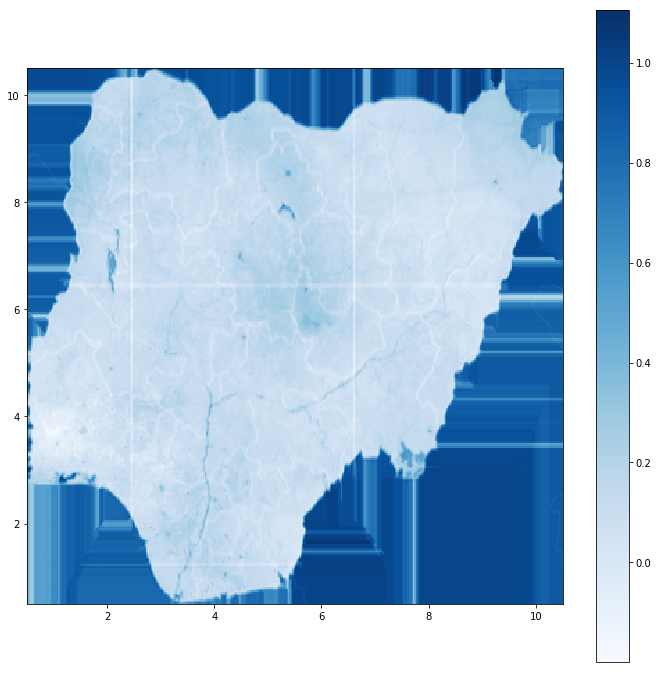

In [60]:
## Creating plot of malaria outbreak 

fig, ax = subplots(figsize=(12, 12))
plt.imshow(m_l,  interpolation='nearest', cmap='Blues', extent=(0.5,10.5,0.5,10.5))
plt.colorbar()
#plt.savefig('logit.png')

In [19]:
## Logistic Regression

logit_mod = smf.logit('Endemicity ~ Resistance + Fever_prop + Mosquito_prop + Temp_suitability + Proximity_to_urban + Urban + Annual_mean_temp + Cropland + Precipitation + Vegetation + Annual_temp_range + Water_bodies', data = data).fit()
print ('\n',logit_mod.summary())

Optimization terminated successfully.
         Current function value: 0.204446
         Iterations 7

                            Logit Regression Results                           
Dep. Variable:             Endemicity   No. Observations:               120432
Model:                          Logit   Df Residuals:                   120420
Method:                           MLE   Df Model:                           11
Date:                Sat, 23 Feb 2019   Pseudo R-squ.:                  0.6884
Time:                        19:23:10   Log-Likelihood:                -24622.
converged:                       True   LL-Null:                       -79016.
                                        LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -4.3881      0.349    -12.562      0.000      -5.073      -3.703
Res

In [ ]:
print (logit_mod.get_margeff().summary())

In [ ]:
## Prediction

data['PredictionLogit'] = logit_mod.predict(data)

In [ ]:
## Creating training/testing data sets w/ both X & Y

data_train = pd.concat([X_train,Y_train],axis=1)
data_test = pd.concat([X_test,Y_test],axis=1)

In [ ]:
## Evaluating Model 

logit_mod_train = smf.logit('Endemicity ~ Resistance + Fever_prop + Temp_suitability + Proximity_to_urban + Urban + Annual_mean_temp + Cropland + Precipitation + Mosquito_prop + Vegetation + Annual_temp_range + Water_bodies', data = data_train).fit()
print (roc_auc_score(np.where(logit_mod_train.predict(data_test)>0.5,1,0), data_test['Endemicity']))

In [ ]:
print (roc_auc_score(np.where(logit_mod_train.predict(data)>0.5,1,0),data['Endemicity']))

In [ ]:
## Linking array to original position of pixels 

file_name='Land_coverage.png'
m=numpy.array(Image.open(file_name)).shape[0]
n=numpy.array(Image.open(file_name)).shape[1]
def indexes(m,n):    
    index_2dim={}
    for M in range(0,m*n):
        #print(M)
        index_2dim[M]={'i':int(M)//int(n), 'j':M-((int(M)//int(n))*n)}
    return index_2dim
#print(index_2dim)
original_index_dict=indexes(m,n)
#print(original_index_dict)[:3]

In [ ]:
## Creating labels to plot 

matrix = np.zeros((m,n))
for M in data.index:
    #print(M)
    i=original_index_dict[M]['i']
    j=original_index_dict[M]['j']
    matrix[i][j]=data.PredictionLogit[M] # Again, getting error on this line on type trying to pass through
m_l=matrix.tolist()



In [ ]:
## Creating plot of malaria outbreak 

fig, ax = subplots(figsize=(12, 12))
plt.imshow(m_l, interpolation='nearest', cmap='Blues', extent=(0.5,10.5,0.5,10.5))
plt.colorbar()
plt.savefig('logit.png')

## Machine Learning (Random Forest)

In [ ]:
max_features = ['log2', 'sqrt', 'log2']

In [ ]:
## Creating function to get the best parameters

def get_results(max_features,criterion,X,Y): 
    kf = KFold(n=len(X), n_folds=4, shuffle=True, random_state=21)
    d = []
    for train_index, test_index in kf:
        for rf_features,criter in itertools.product(max_features,criterion): #,rf_estimators,n_estimators
            X_tr, X_test = X[train_index], X[test_index]
            X_train, X_validation = train_test_split(X_tr, test_size=0.2, random_state=21)
            Y_tr, Y_test = Y[train_index], Y[test_index]
            Y_train, Y_validation = train_test_split(Y_tr, test_size=0.2, random_state=21)
            del X_tr
            del Y_tr
            forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion=criter,
                    max_depth=None, max_features=rf_features, max_leaf_nodes=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                    oob_score=False, random_state=21, verbose=0,
                    warm_start=False)
            forest.fit(X_train,Y_train)
            forest_pred = forest.predict(X_validation)
            name = '%s,%s,%s'%(str(rf_features),str(criter),str(100))
            d.append((name,roc_auc_score(Y_validation,forest_pred),X_train,X_test,Y_train,Y_test))
    return sorted(d, key=lambda tup: tup[1])[-1]

In [ ]:
%%time
## Getting best parameters

best = get_results(max_features,criterion,X[['Precipitation','Annual_temp_range','Resistance']].as_matrix(),Y.as_matrix())
best_params,X_train_best,X_test_best,Y_train_best,Y_test_best = best[0].split(','),best[2],best[3],best[4],best[5]

# Running Random Forest 
forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion=best_params[1],
                max_depth=None, max_features=best_params[0], max_leaf_nodes=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=int(best_params[2]), n_jobs=-1,
                oob_score=False, random_state=21, verbose=0,
                warm_start=False)
forest.fit(X_train_best,Y_train_best)


### Random Forest without Gridsearch

In [ ]:
max_features = 'log2'
criterion = 'gini'
n_estimators = 1000 # Playing around with

In [ ]:
## Running Random Forest again, without gridsearch

%%time
kf = KFold(n=len(X), n_folds=6, shuffle=True, random_state=21)
d = []
for train_index, test_index in kf:
    X_tr, X_test = X.as_matrix()[train_index], X.as_matrix()[test_index]
    X_train, X_validation = train_test_split(X_tr, test_size=0.2, random_state=21)
    Y_tr, Y_test = Y.as_matrix()[train_index], Y.as_matrix()[test_index]
    Y_train, Y_validation = train_test_split(Y_tr, test_size=0.2, random_state=21)
    del X_tr
    del Y_tr
    forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion=criterion,
            max_depth=None, max_features=max_features, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=n_estimators, n_jobs=-1,
            oob_score=False, random_state=21, verbose=0,
            warm_start=False)
    forest.fit(X_train,Y_train)
    forest_pred = forest.predict(X_validation)
    d.append((roc_auc_score(Y_validation,forest_pred),X_train,X_test,Y_train,Y_test))

In [ ]:
print sorted(d, key=lambda tup: tup[0])[-1][0]